# Convergence Comparison: Binomial vs Monte Carlo vs PDE

In this notebook, We compare how the estimated European **call** price converges to the
Black–Scholes analytic value as we refine the resolution in three methods:

- Binomial Tree Method  
- Monte Carlo Simulation  
- Finite Difference PDE (Crank-Nicolson)

We observe the convergence trends and computational efficiency of each.

| Symbol    | Meaning                    | Value              |
|:---------:|:--------------------------:|:------------------:|
| \(S_0\)    | Spot price                 | **100**            |
| \(K\)      | Strike                     | 100                |
| \(r\)      | Risk-free rate             | 5 %                |
| \(\sigma\) | Volatility                 | 20 %               |
| \(T\)      | Maturity (years)           | 1.0                |
| BSM price  | Black–Scholes reference    | computed below     |
| Binomial   | Number of steps \(N\)      | 10,20,…,200        |
| Monte Carlo| Number of paths \(N\)      | \(10^2,…,10^5\)    |
| PDE        | Grid size \(N_S=N_t=N\)    | 10,20,…,100        |

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os, sys

sys.path.append(os.path.abspath("../../"))

from pricing.bsm import bsm_price
from pricing.binomial_tree import binomial_crr_price
from pricing.monte_carlo import mc_european_price
from pricing.pde import crank_nicolson

In [2]:
# Parameters

S0 = 100
K = 100
T = 1.0
r = 0.05
sigma = 0.2
is_call = True

# analytic reference
price_bs = bsm_price(S0, K, r, sigma, T, is_call=True)
print(f"Black–Scholes price = {price_bs:.4f}")

Black–Scholes price = 10.4506


In [3]:
# Binomial
bin_steps = np.arange(10, 210, 10)
bin_prices = []
bin_errors = []
for N in bin_steps:
    p = binomial_crr_price(S0, K, r, sigma, T, N, is_call=True)
    bin_prices.append(p)
    bin_errors.append(abs(p - price_bs))

# Monte Carlo
mc_paths = np.logspace(2, 5, 10, dtype=int)
mc_prices = []
mc_errors = []
mc_cis = []
for N in mc_paths:
    p, ci = mc_european_price(
        S0, K, r, sigma, T, N_paths=N, N_steps=1, is_call=True, seed=42
    )
    mc_prices.append(p)
    mc_cis.append(ci)
    mc_errors.append(abs(p - price_bs))

# PDE
pde_steps = np.arange(10, 110, 10)
pde_prices = []
pde_errors = []
for N in pde_steps:
    p = crank_nicolson(S0, K, r, sigma, T, Smax=4 * K, N_S=N, N_t=N, is_call=True)
    pde_prices.append(p)
    pde_errors.append(abs(p - price_bs))

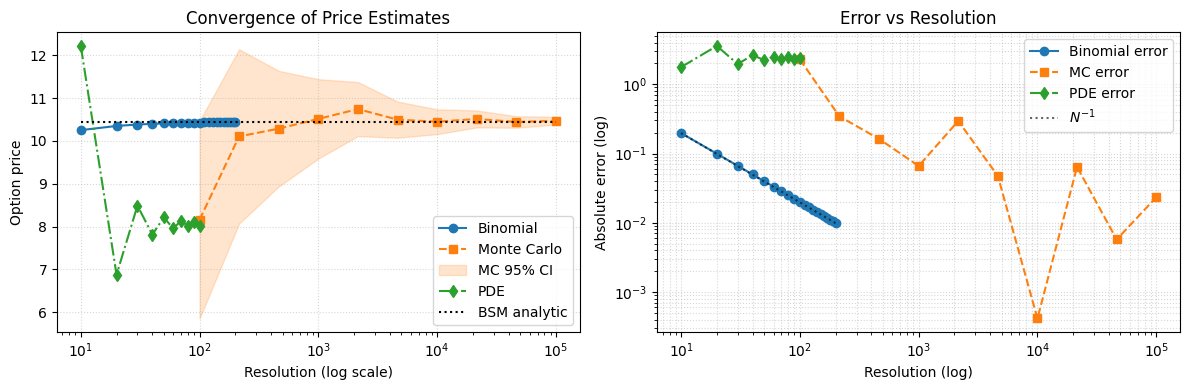

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# — Price convergence —
ax1.plot(bin_steps, bin_prices, "o-", label="Binomial")
ax1.plot(mc_paths, mc_prices, "s--", label="Monte Carlo")
ax1.fill_between(
    mc_paths,
    np.array(mc_prices) - np.array(mc_cis),
    np.array(mc_prices) + np.array(mc_cis),
    color="C1",
    alpha=0.2,
    label="MC 95% CI",
)
ax1.plot(pde_steps, pde_prices, "d-.", label="PDE")
ax1.hlines(
    price_bs,
    bin_steps[0],
    mc_paths[-1],
    colors="k",
    linestyles=":",
    label="BSM analytic",
)
ax1.set_xscale("log")
ax1.set_xlabel("Resolution (log scale)")
ax1.set_ylabel("Option price")
ax1.set_title("Convergence of Price Estimates")
ax1.legend()
ax1.grid(ls=":", alpha=0.5)

# — Error convergence (log–log) —
ax2.loglog(bin_steps, bin_errors, "o-", label="Binomial error")
ax2.loglog(mc_paths, mc_errors, "s--", label="MC error")
ax2.loglog(pde_steps, pde_errors, "d-.", label="PDE error")
# reference slopes
ref1 = bin_errors[0] * (bin_steps / bin_steps[0]) ** -1.0
ax2.loglog(bin_steps, ref1, "k:", alpha=0.6, label=r"$N^{-1}$")
ax2.set_xlabel("Resolution (log)")
ax2.set_ylabel("Absolute error (log)")
ax2.set_title("Error vs Resolution")
ax2.legend()
ax2.grid(which="both", ls=":", alpha=0.5)

plt.tight_layout()

# save the plot into plots folder
plt.savefig("../../plots/mc_pde_binomial_convergence.png", dpi=300)

plt.show()

### Observations

- **Binomial** converges *monotonically* at roughly \(O(N^{-1})\) to the BSM price.  
- **Monte Carlo** shows noisy convergence, but the estimates lie within its 95 % CI band once \(N\gtrsim10^4\).  
- **PDE (CN)** converges rapidly and deterministically, reaching cent-level error by \(N=40\).  

**Conclusion:**  
PDE offers the fastest, most reliable convergence for vanilla calls;  
MC remains useful for path‐dependent payoffs but requires many paths;  
binomial trees are simple and effective when very fine grids are affordable.